## Laboratorium 8.1


## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Wiele z tych metod działa także dla (trójwymiarowego) sygnału wideo, jeśli - nieco naiwnie - potraktujemy go jako po prostu sekwencję niezależnych obrazów.

W tej liście wykorzystasz także dziedziną czasową do przetwarzania sygnału. Podstawowa intuicja polega na tym, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Jedną z najpowszechniejszych metodą do automatycznej detekcji ruchu jest znana Ci już z wykładu metoda przepływu optycznego (ang. _optical flow_). Namawiam też do lektury [artykułu z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), zwłaszcza sekcji _Lucas-Kanade_ oraz _Dense Optical Flow_. Analizując kod metody, poświęć chwilę na zrozumienie mapowania wyników do prezentowanego obrazu w przestrzeni HSV.

Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:,
* przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela (na tej metodzie skupia się niniejsza część listy),
* przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (przebadasz ją w drugiej części listy).

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.

### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując wektory translacji pomiędzy rejonami z jednej i drugiej. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną $I(x,y,t)$ i poprzednią $I(x,y,t-1)$.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu sprzętowego działającego w czasie rzeczywistym). Idea jest prosta:
* tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
* pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:
```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).

Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Zadanie 1

#### Zadanie 1a
Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci obrazu całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.

In [48]:
from PIL import Image
from matplotlib import pyplot as plt


def display_frame(frame):
    # Convert the frame to RGB (OpenCV uses BGR by default)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Convert the frame to a PIL image
    img = Image.fromarray(frame_rgb)
    # Display the image using matplotlib
    plt.imshow(img)
    plt.axis("off")  # Hide the axis
    plt.show()

In [49]:
kick_path = 'dane/kick.mp4'
back_path = 'dane/back.mp4'

desired_time = 0.7

def get_vid(path, desired_time, fps=25):
    cap = cv2.VideoCapture(path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, fps * desired_time)
    return cap


vid_kick = get_vid(kick_path, desired_time)
kick_frame_1 = vid_kick.read()[1]
kick_frame_2 = vid_kick.read()[1]

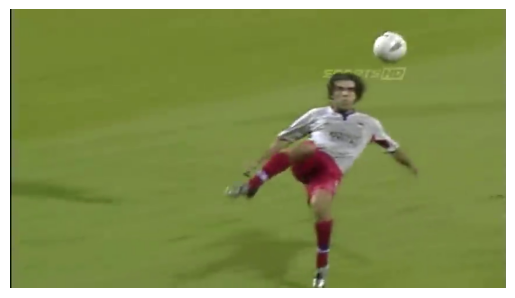

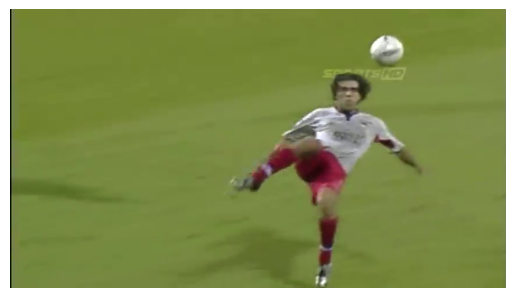

(None, None)

In [50]:
display_frame(kick_frame_1), display_frame(kick_frame_2)

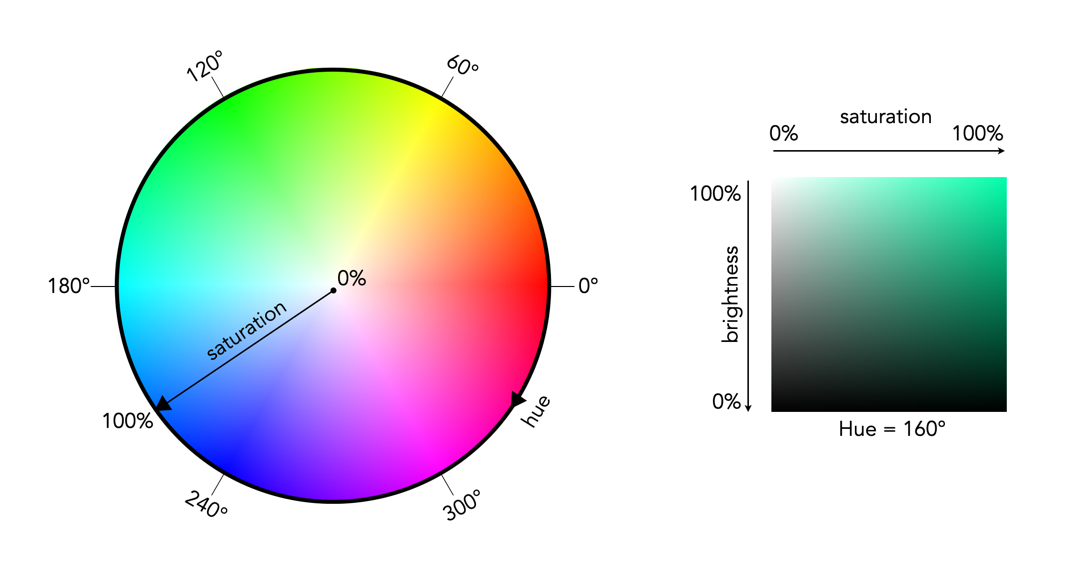

In [51]:
def visualize_optical_flow(
        frame1, 
        frame2,
        pyr_scale=0.5,
        levels=3,
        winsize=15,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0
        ):
    # Convert frames to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow using Farneback method
    flow = cv2.calcOpticalFlowFarneback(
        gray1, gray2, None, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags
    )

    # Calculate magnitude and angle of the flow
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Create an HSV image
    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    # Convert HSV to BGR
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return bgr

def display_frames_with_visualized_flow(frame1, frame2, winsize=15):
    flow_visualization = visualize_optical_flow(frame1, frame2, winsize=winsize)

    # Display the frames
    fig, ax = plt.subplots(1, 4, figsize=(25, 5))
    ax[0].imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
    ax[0].axis("off")
    ax[0].set_title("Frame 1")

    ax[1].imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
    ax[1].axis("off")
    ax[1].set_title("Frame 2")

    # Frames weighted by 50/50

    ax[2].imshow(cv2.cvtColor(cv2.addWeighted(frame1, 0.5, frame2, 0.5, 0), cv2.COLOR_BGR2RGB))
    ax[2].axis("off")
    ax[2].set_title("Weighted Frames")
    

    ax[3].imshow(cv2.cvtColor(flow_visualization, cv2.COLOR_BGR2RGB))
    ax[3].axis("off")
    ax[3].set_title("Optical Flow")

    plt.show()


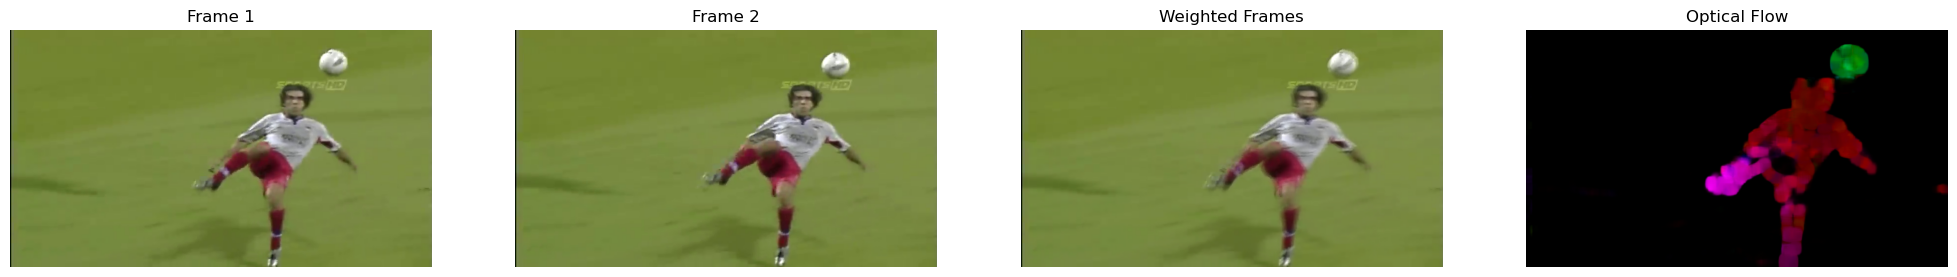

In [52]:
display_frames_with_visualized_flow(kick_frame_1, kick_frame_2)

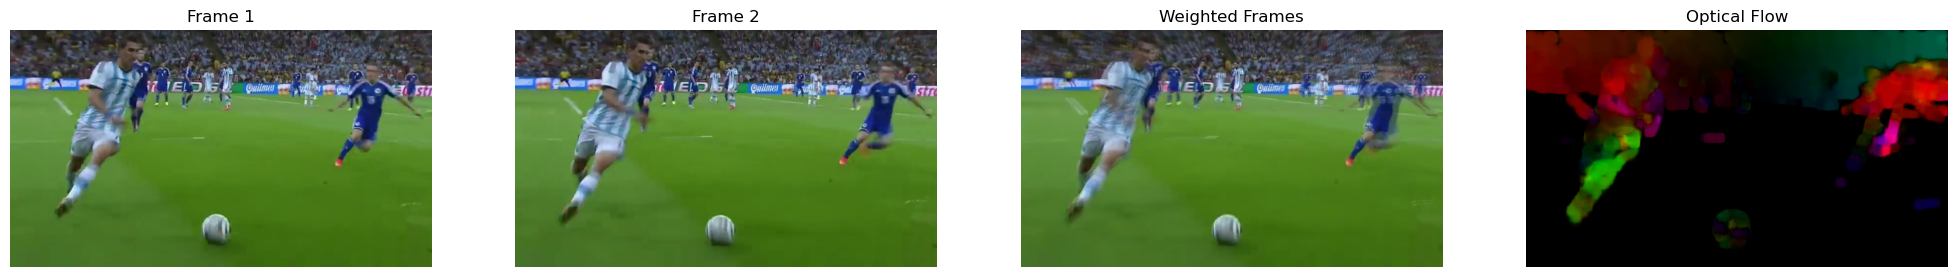

In [53]:
vid_back = get_vid(back_path, desired_time)
back_frame_1 = vid_back.read()[1]
back_frame_2 = vid_back.read()[1]

display_frames_with_visualized_flow(back_frame_1, back_frame_2)

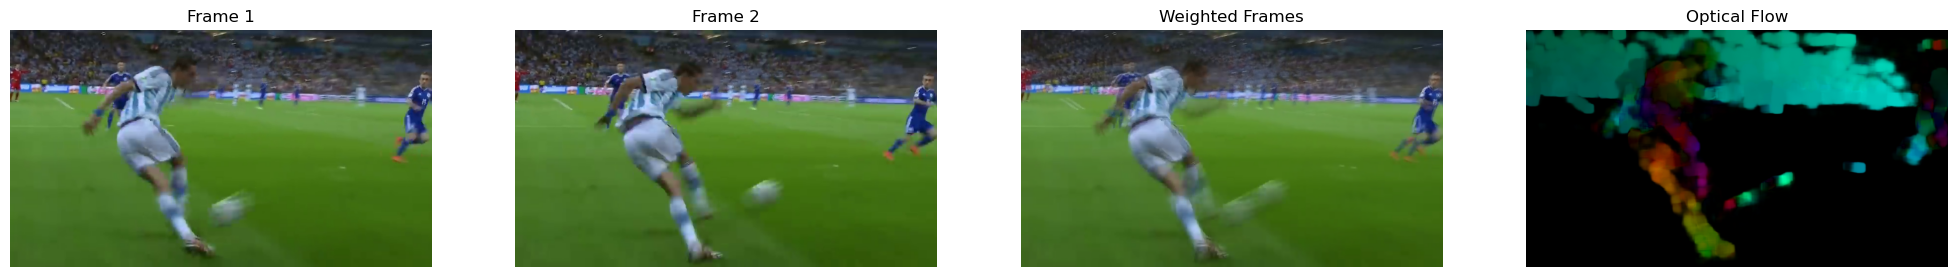

In [54]:
vid_back = get_vid(back_path, 1.2)
back_frame_1 = vid_back.read()[1]
back_frame_2 = vid_back.read()[1]

display_frames_with_visualized_flow(back_frame_1, back_frame_2)

#### Zadanie 1b
Zbadaj wpływ parametru `winsize` na działanie metody.

Win size: 1


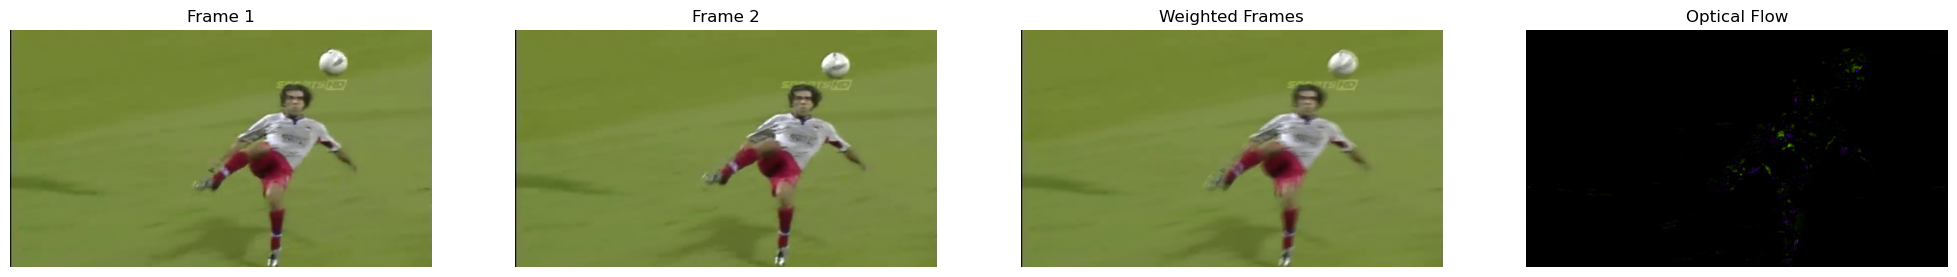

Win size: 6


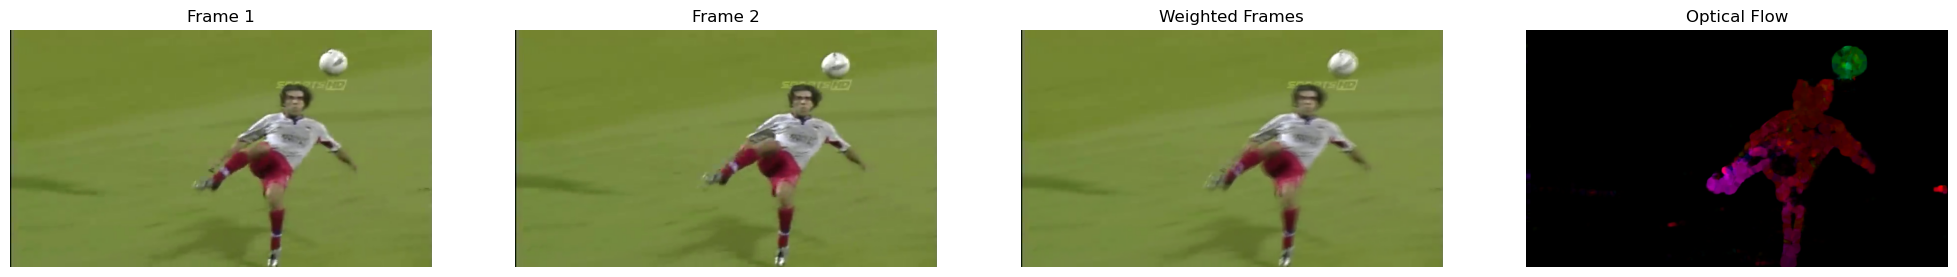

Win size: 11


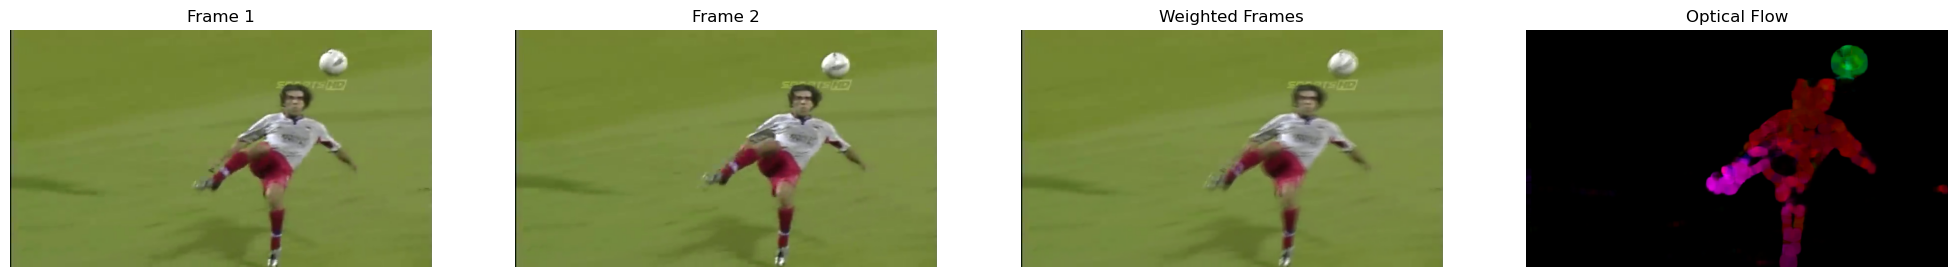

Win size: 16


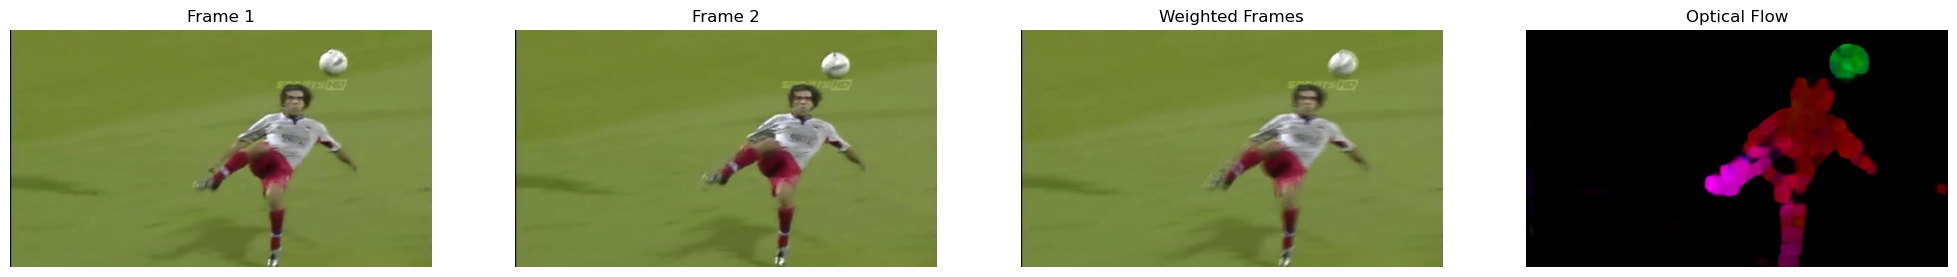

Win size: 21


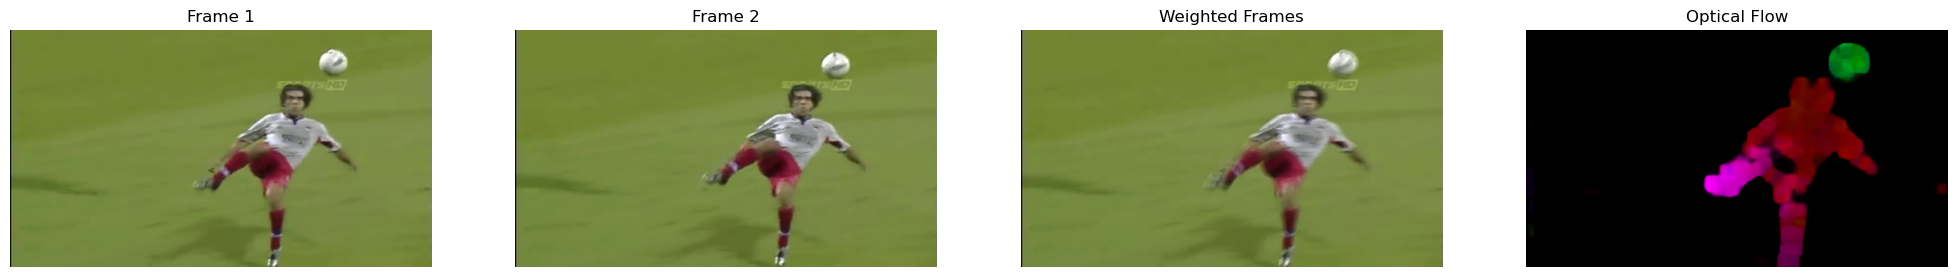

In [55]:
vid_kick = get_vid(kick_path, 0.7)
kick_frame_1 = vid_kick.read()[1]
kick_frame_2 = vid_kick.read()[1]

for i in range(1, 26, 5):
    print(f"Win size: {i}")
    display_frames_with_visualized_flow(kick_frame_1, kick_frame_2, winsize=i)

Win size: 1


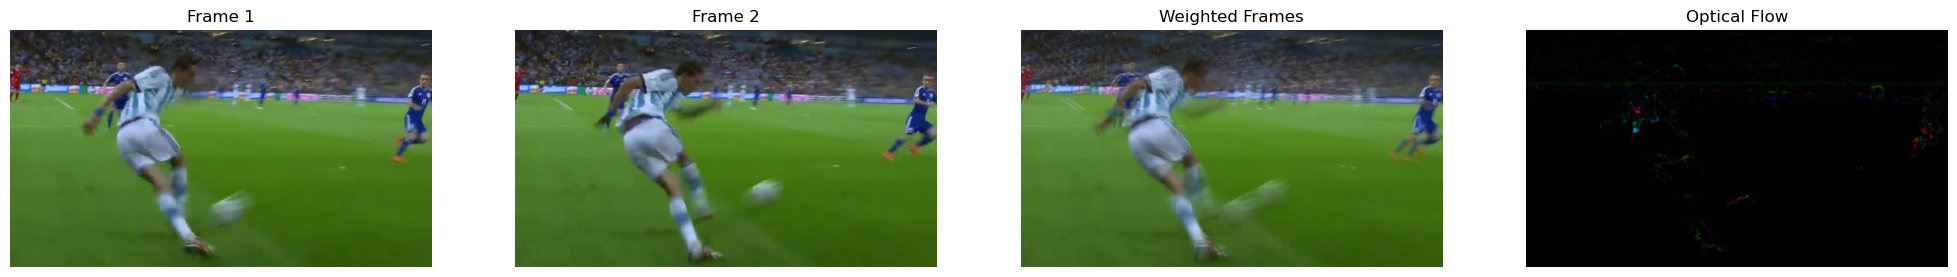

Win size: 6


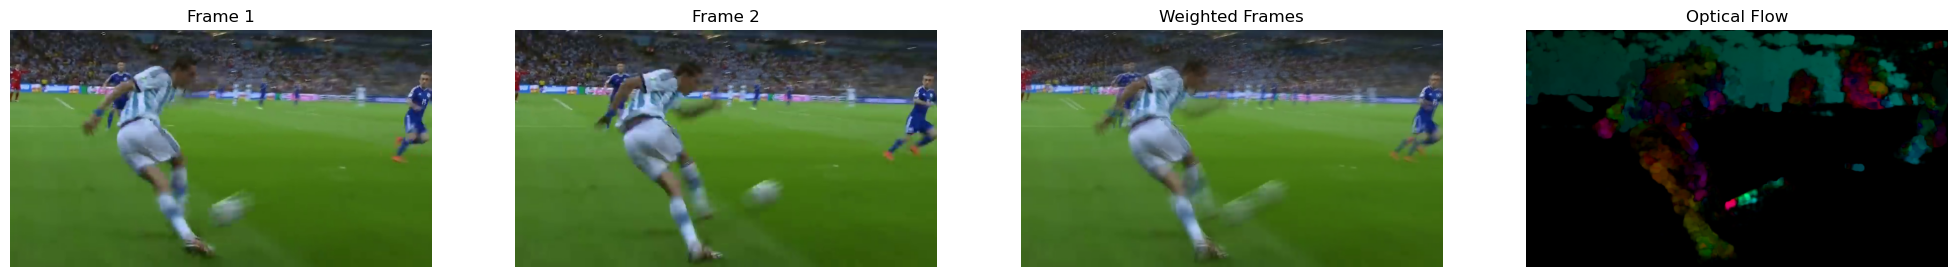

Win size: 11


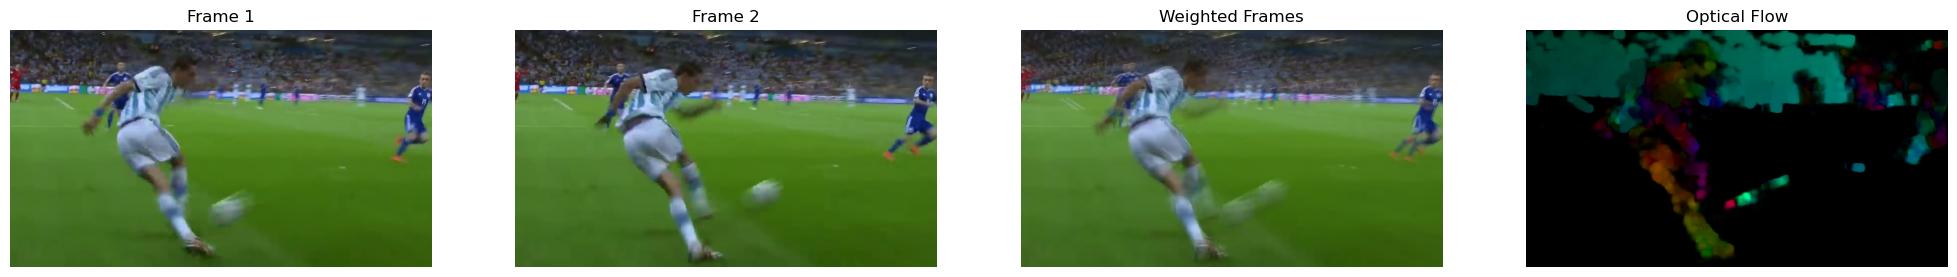

Win size: 16


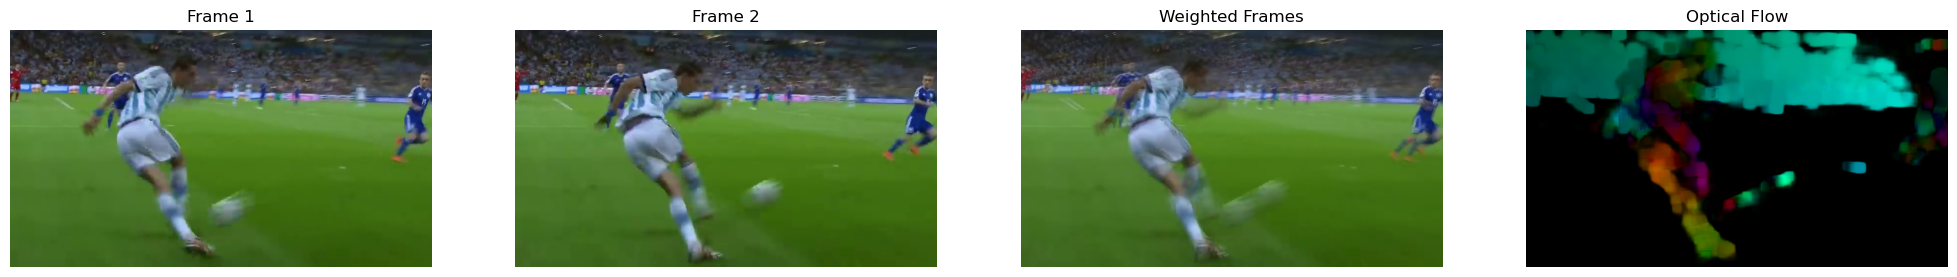

Win size: 21


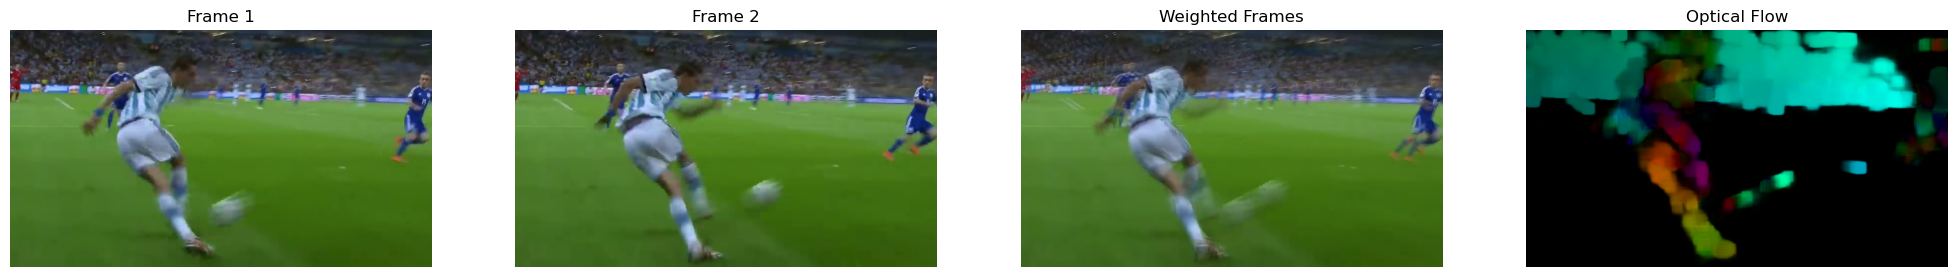

In [56]:
vid_back = get_vid(back_path, 1.2)
back_frame_1 = vid_back.read()[1]
back_frame_2 = vid_back.read()[1]

for i in range(1, 26, 5):
    print(f"Win size: {i}")
    display_frames_with_visualized_flow(back_frame_1, back_frame_2, winsize=i)

Komentarz 1:

- Wolniejsze zmainy w obrazie `kick` powoduja, że algorytm jest w stanie łatwo wykryć ruch. W przypadku obrazu `back` algorytm ma problem z szybkimi zmianami w obrazie.
- Kolory odpowiadają kierunkowi przesunięcia piksela według skali  H z przestrzeni HSV
- winsize - większe wartości zwiększają odporność algorytmu na zakłócenia obrazu i dają większe szanse na szybkie wykrywanie ruchu, ale dają bardziej rozmyte pole ruchu.

---

### Zadanie 2

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu natychmiast po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
*Czy algorytm działa tak samo dobrze? Dlaczego? Co jest ograniczeniem metody?*

Win size: 1


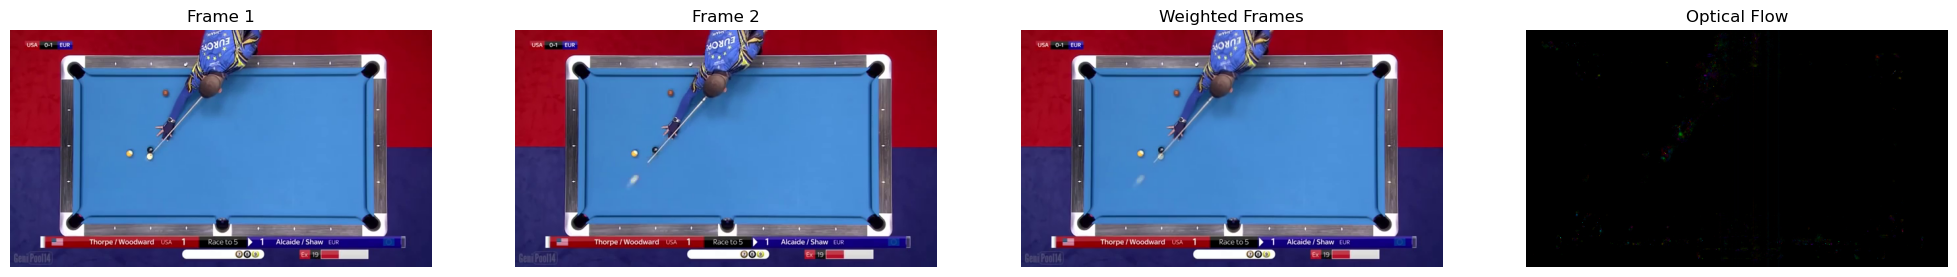

Win size: 6


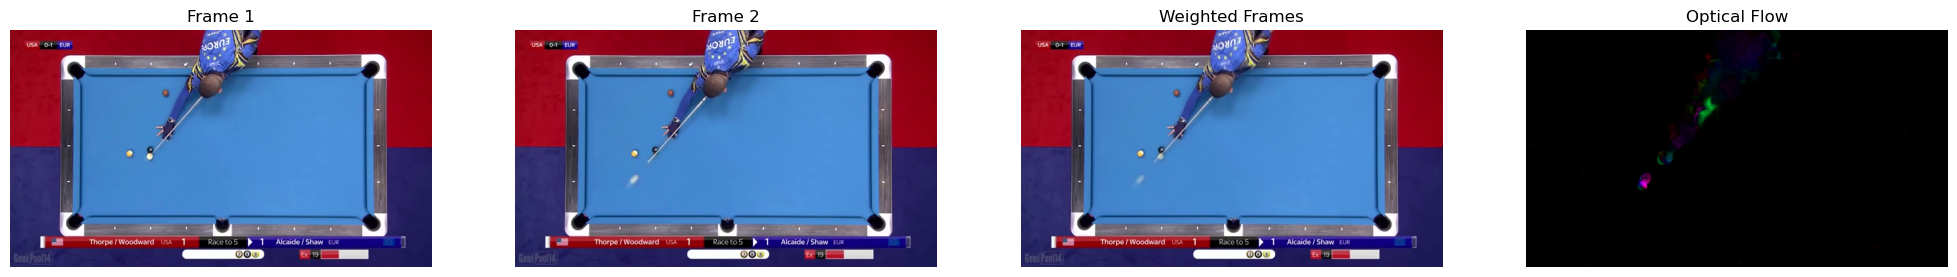

Win size: 11


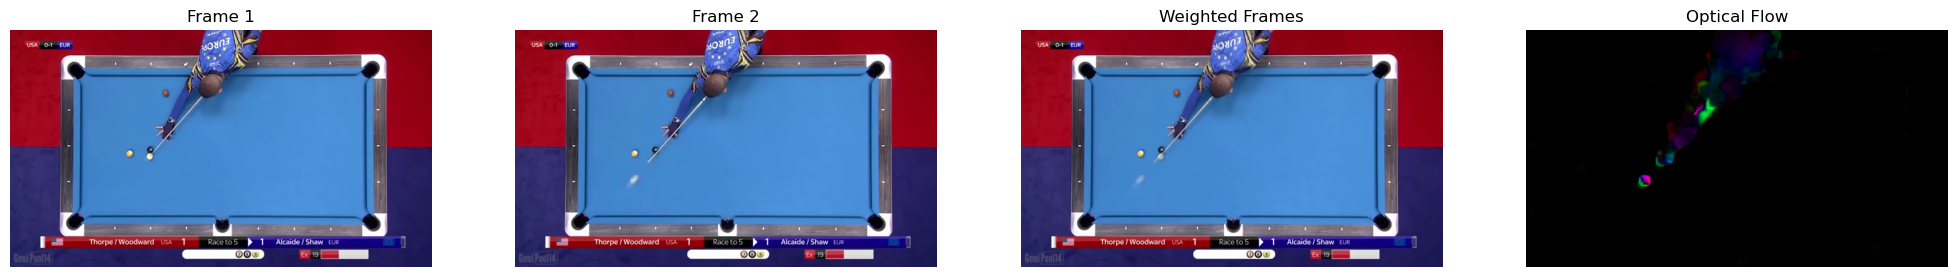

Win size: 16


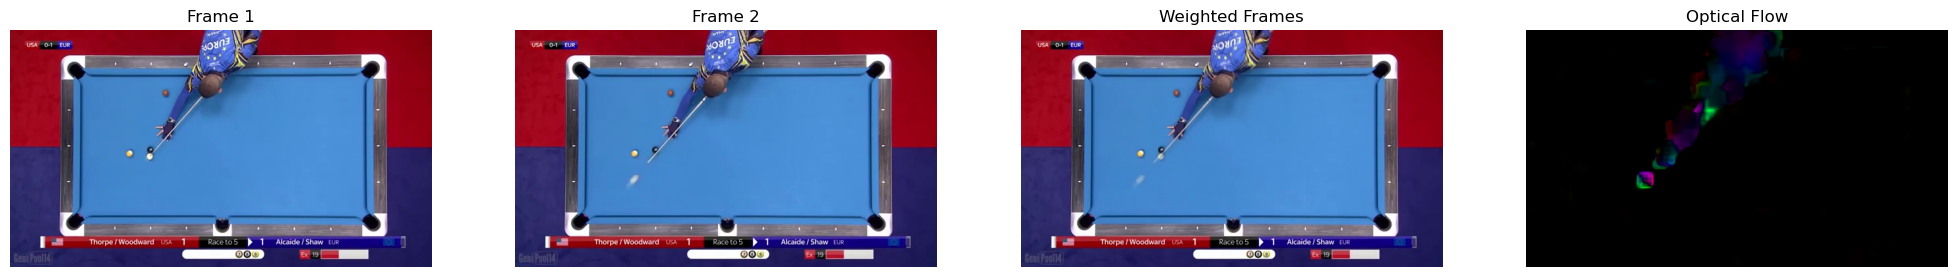

Win size: 21


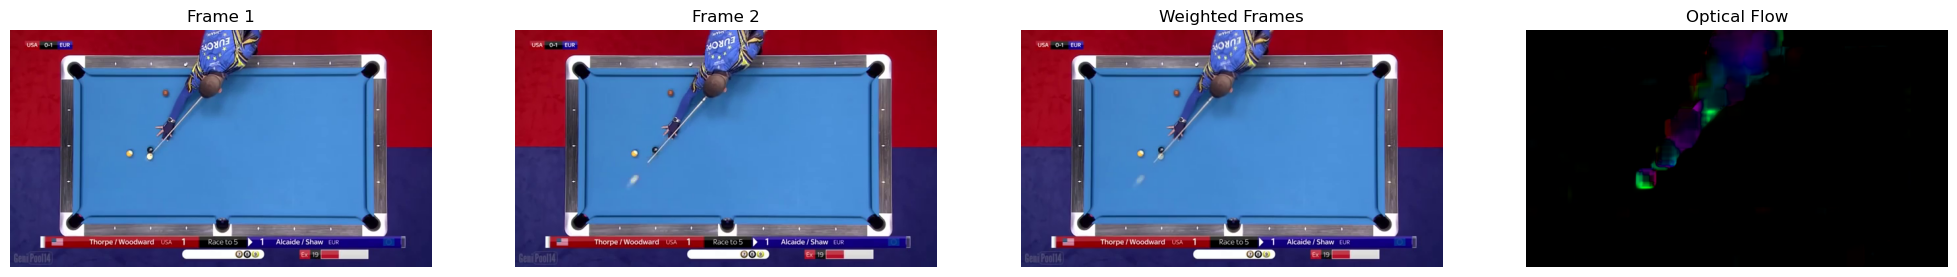

In [57]:
shot_path = 'dane/shot.mp4'

vid_shot = get_vid(shot_path, 1.35, fps=15)
shot_frame_1 = vid_shot.read()[1]
shot_frame_2 = vid_shot.read()[1]

for i in range(1, 26, 5):
    print(f"Win size: {i}")
    display_frames_with_visualized_flow(shot_frame_1, shot_frame_2, winsize=i)

Win size: 1


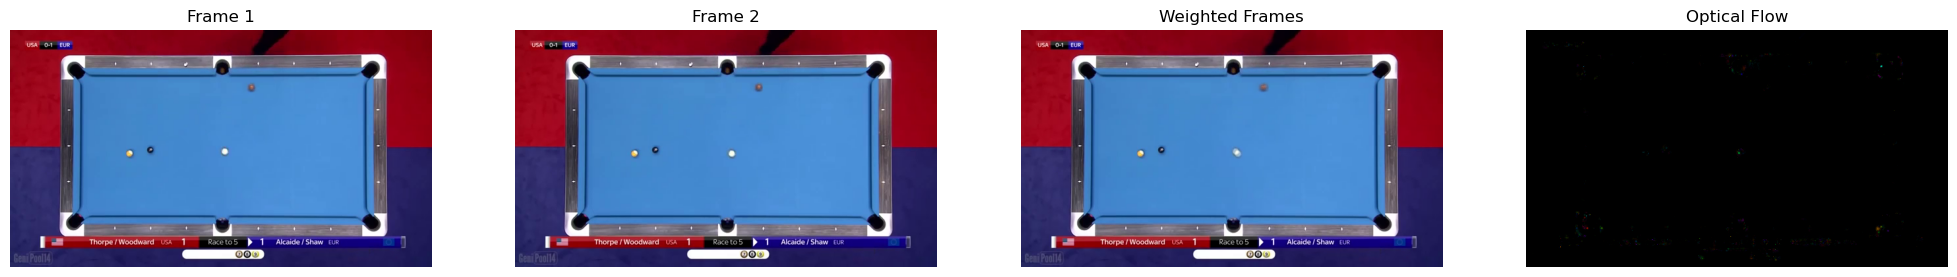

Win size: 6


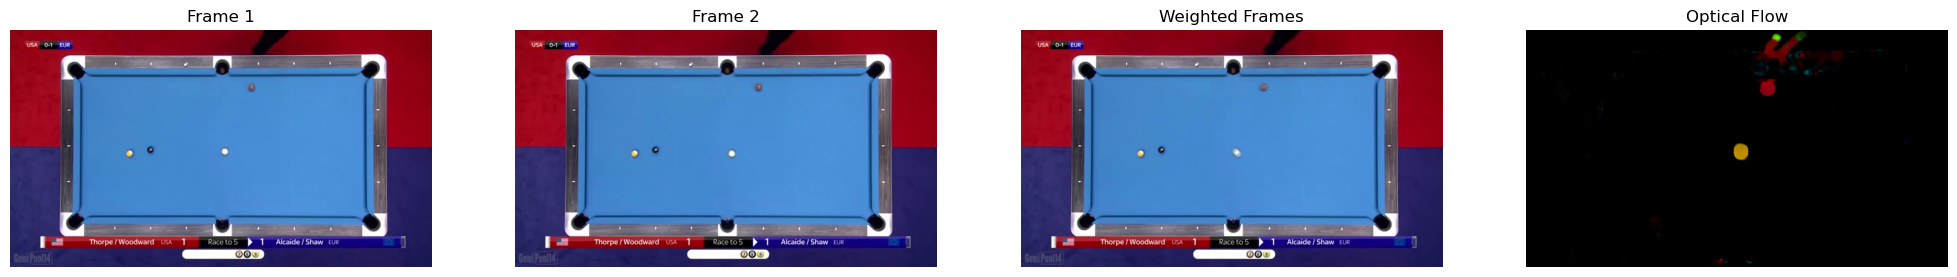

Win size: 11


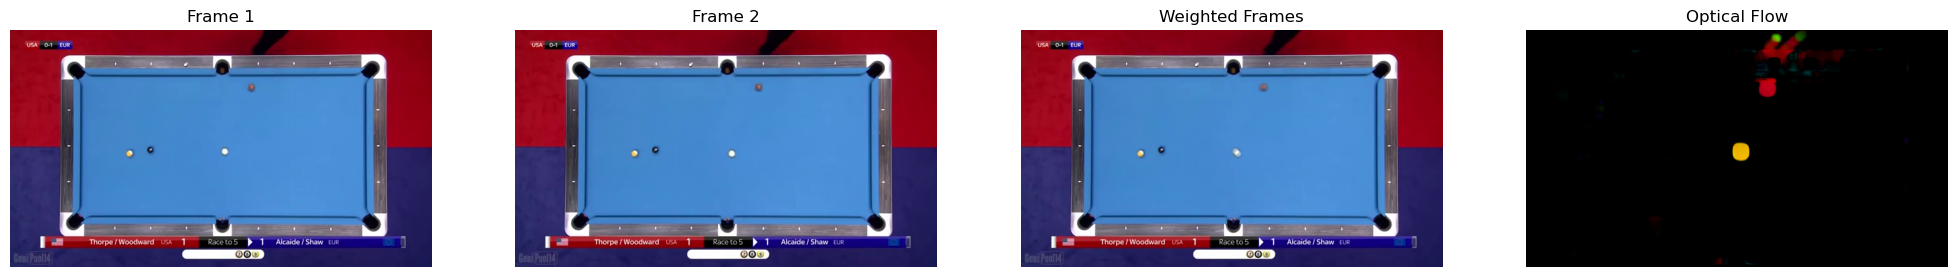

Win size: 16


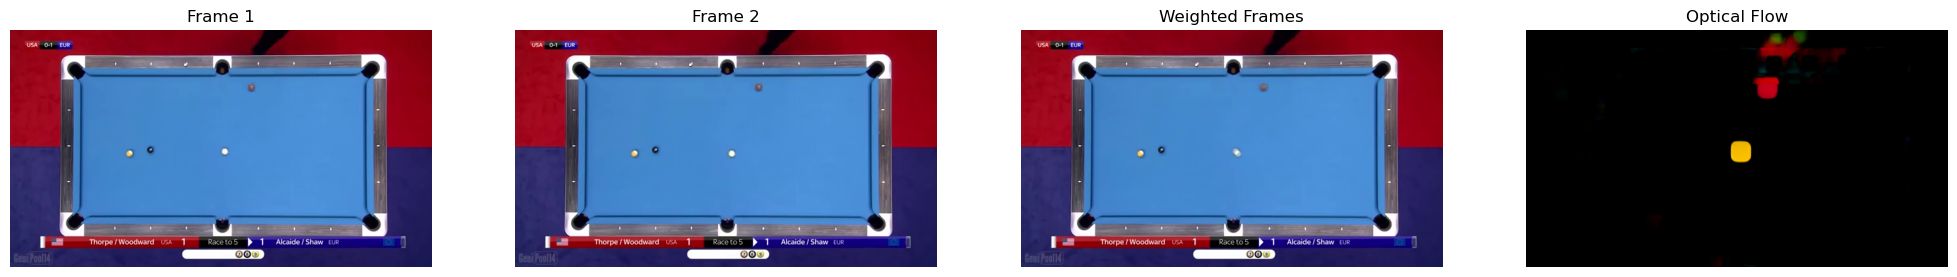

Win size: 21


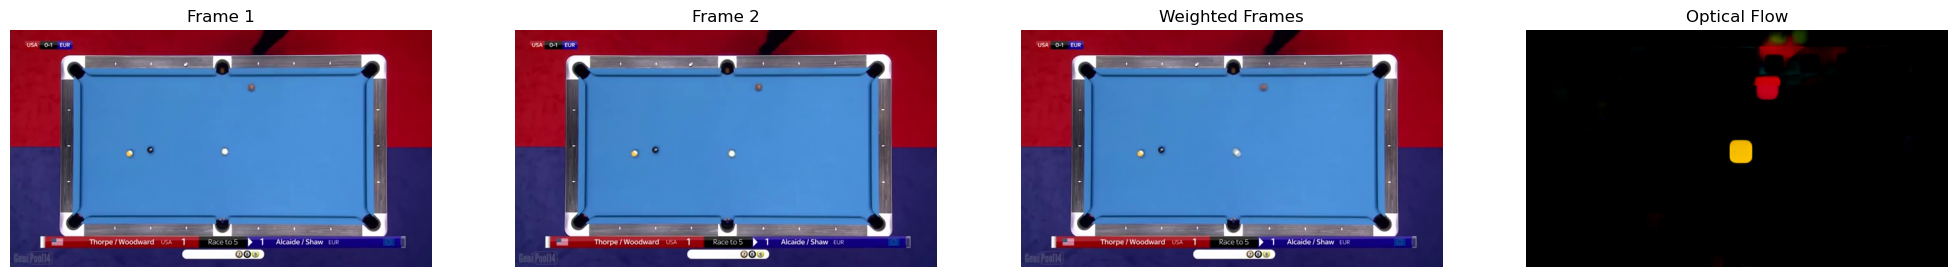

In [58]:
shot_path = 'dane/shot.mp4'

vid_shot = get_vid(shot_path, 3.5, fps=15)
shot_frame_1 = vid_shot.read()[1]
shot_frame_2 = vid_shot.read()[1]

for i in range(1, 26, 5):
    print(f"Win size: {i}")
    display_frames_with_visualized_flow(shot_frame_1, shot_frame_2, winsize=i)

Komentarz 2:

- piłka jest bardzo mała i szybko się porusza, co sprawia, że algorytm ma problem z wykryciem ruchu oraz wykrywa go w 2 kierunkach.
- algorytm bardziej znajduje ruch uderzającego w bilę, niż samej bili.

### Zadanie dla chętnych

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).